# Neural Collaborative Filtering





TODO: check if validation don't has previous user ratings

## IMPORTS



### Libraries

In [115]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import torch 

from tqdm.notebook import tqdm
from ncf_trainer import NCFTrainer
from feature_processor import FeatureProcessor

from candidate_generator import CandidateGenerator
from validate_model import validate_model_with_features
from ncf import NCF
from cold_start import ColdStartRecommender

np.random.seed(123)

os.environ["TOKENIZERS_PARALLELISM"] = "false"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Control Variables

In [62]:
SAMPLE=False
NUM_EPOCHS = 100
DEBUG=False

## Load Dataset

In [ ]:
ratings = pd.read_csv("../two_towers/data/ml-1m/ratings.dat", sep="::", header=None, engine='python')
ratings.columns = ["user_id", "movie_id", "rating", "timestamp"]

movies = pd.read_csv("../two_towers/data/ml-1m/movies.dat", sep="::", header=None, engine='python')
movies.columns = ["movie_id", "title", "genres"]

users = pd.read_csv("../two_towers/data/ml-1m/users.dat", sep="::", header=None, engine='python')
users.columns = ["user_id", "gender", "age", "occupation", "zip_code"]


/tmp/ipykernel_1533366/496125939.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv("../two_towers/data/ml-1m/ratings.dat", sep="::", header=None)
/tmp/ipykernel_1533366/496125939.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies = pd.read_csv("../two_towers/data/ml-1m/movies.dat", sep="::", header=None)
/tmp/ipykernel_1533366/496125939.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='pyt

## Preprocess Data

- Sample data

In [33]:
if SAMPLE:
    rand_userIds = np.random.choice(ratings['user_id'].unique(),
                                size=int(len(ratings['user_id'].unique())*0.1),
                                replace=False)
    ratings = ratings.loc[ratings['user_id'].isin(rand_userIds)]


- Develop features

In [48]:
# Initialize feature processor and prepare features
print("Preparing user and movie features...")

feature_processor = FeatureProcessor(debug=DEBUG)

user_features_df = feature_processor.prepare_user_features(users)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")
movie_embeddings = feature_processor.prepare_movie_features(movies, device=device)

print(f"\nFeature preparation complete!")
print(f"User feature dimension: {feature_processor.user_feature_dim}")
print(f"Movie feature dimension: {feature_processor.movie_feature_dim}")


Preparing user and movie features...
User feature dimension: 29
Using device: cpu
Encoding movie titles...
Encoding movie genres...
Normalizing movie embeddings...

Feature preparation complete!
User feature dimension: 29
Movie feature dimension: 768


- Check ratings dataset size

In [38]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1000209 non-null  int64
 1   movie_id   1000209 non-null  int64
 2   rating     1000209 non-null  int64
 3   timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


- Set one leaving out validation for recommendation

In [126]:
ratings['rank_latest'] = ratings.groupby(['user_id'])['timestamp'] \
                                .rank(method = 'first',ascending=False)

# Training: Take all ratings except the last 2 (penultimate and latest)
train_ratings = ratings[~ratings['rank_latest'].isin([1,2])]

# Validation: Take the penultimate rating (rank = 2) 
validation_ratings = ratings[ratings['rank_latest'] == 2]

# Test: Take the latest rating (rank = 1)
test_ratings = ratings[ratings['rank_latest'] == 1]

# drop columns that we no longer need 
train_ratings = train_ratings[['user_id', 'movie_id', 'rating']]
validation_ratings = validation_ratings[['user_id', 'movie_id', 'rating']]  # Added this line
test_ratings = test_ratings[['user_id','movie_id','rating']]

In [127]:
train_ratings.shape[0] , validation_ratings.shape[0] , test_ratings.shape[0]

(988129, 6040, 6040)

In [39]:
# set total global variables

NUM_USERS = ratings['user_id'].max()+1
NUM_ITEMS = ratings['movie_id'].max()+1

ALL_MOVIEIDS = ratings['movie_id'].unique()

## Pre-compute candidates generation

In [128]:
candidate_gen = CandidateGenerator(train_ratings, movies, ALL_MOVIEIDS)


In [129]:
train_candidates = candidate_gen.precompute_training_candidates(train_ratings, method="hybrid")

Precomputing training candidates for 6040 users...


Precomputing training candidates:   0%|          | 0/6040 [00:00<?, ?it/s]

Precomputing training candidates: 100%|██████████| 6040/6040 [00:26<00:00, 224.13it/s]

Precomputed training candidates for 6040 users


In [130]:
validation_candidates =  candidate_gen.precompute_validation_candidates(validation_ratings, train_ratings, method="hybrid", num_candidates=100)

Precomputing validation candidates for 6040 users...


Precomputing validation candidates:   0%|          | 22/6040 [00:00<00:28, 208.05it/s]

Precomputing validation candidates: 100%|██████████| 6040/6040 [00:31<00:00, 192.97it/s]

Precomputed validation candidates for 6040 users


## Train Model

In [ ]:

if device is None:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = NCF(
    user_feature_dim=feature_processor.user_feature_dim,
    movie_feature_dim=feature_processor.movie_feature_dim,
    ratings=train_ratings,
    feature_processor=feature_processor,
    precomputed_candidates=train_candidates,
    num_negatives=4
)

model = model.to(device)

trainer = NCFTrainer(
    model=model,
    train_ratings=train_ratings,
    validation_ratings=validation_ratings,
    validation_candidates=validation_candidates,
    feature_processor=feature_processor,
    device=device,
    patience=20,
    min_delta=0.001,
)

training_results = trainer.train(
    num_epochs=100,
    batch_size=512,
    verbose=True,
    total_users_to_test=500,
)


Generating training dataset with precomputed candidates


Processing users: 100%|██████████| 6040/6040 [00:04<00:00, 1500.72it/s]


Generated 1582881 samples (988129 positive, 594752 negative)
Negative-to-positive ratio: 0.60


Training:   1%|          | 1/100 [00:38<1:04:14, 38.93s/it]

Epoch 1/100
  Training Loss: 0.5450
  Validation Loss: 0.3988
  Hit Ratio @ 10: 0.364
  MRR: 0.152
  Mean Rank: 26.3
--------------------------------------------------


In [ ]:
trainer.save_model("models/best_ncf_model.pth")

Metrics plot saved to training_metrics.png


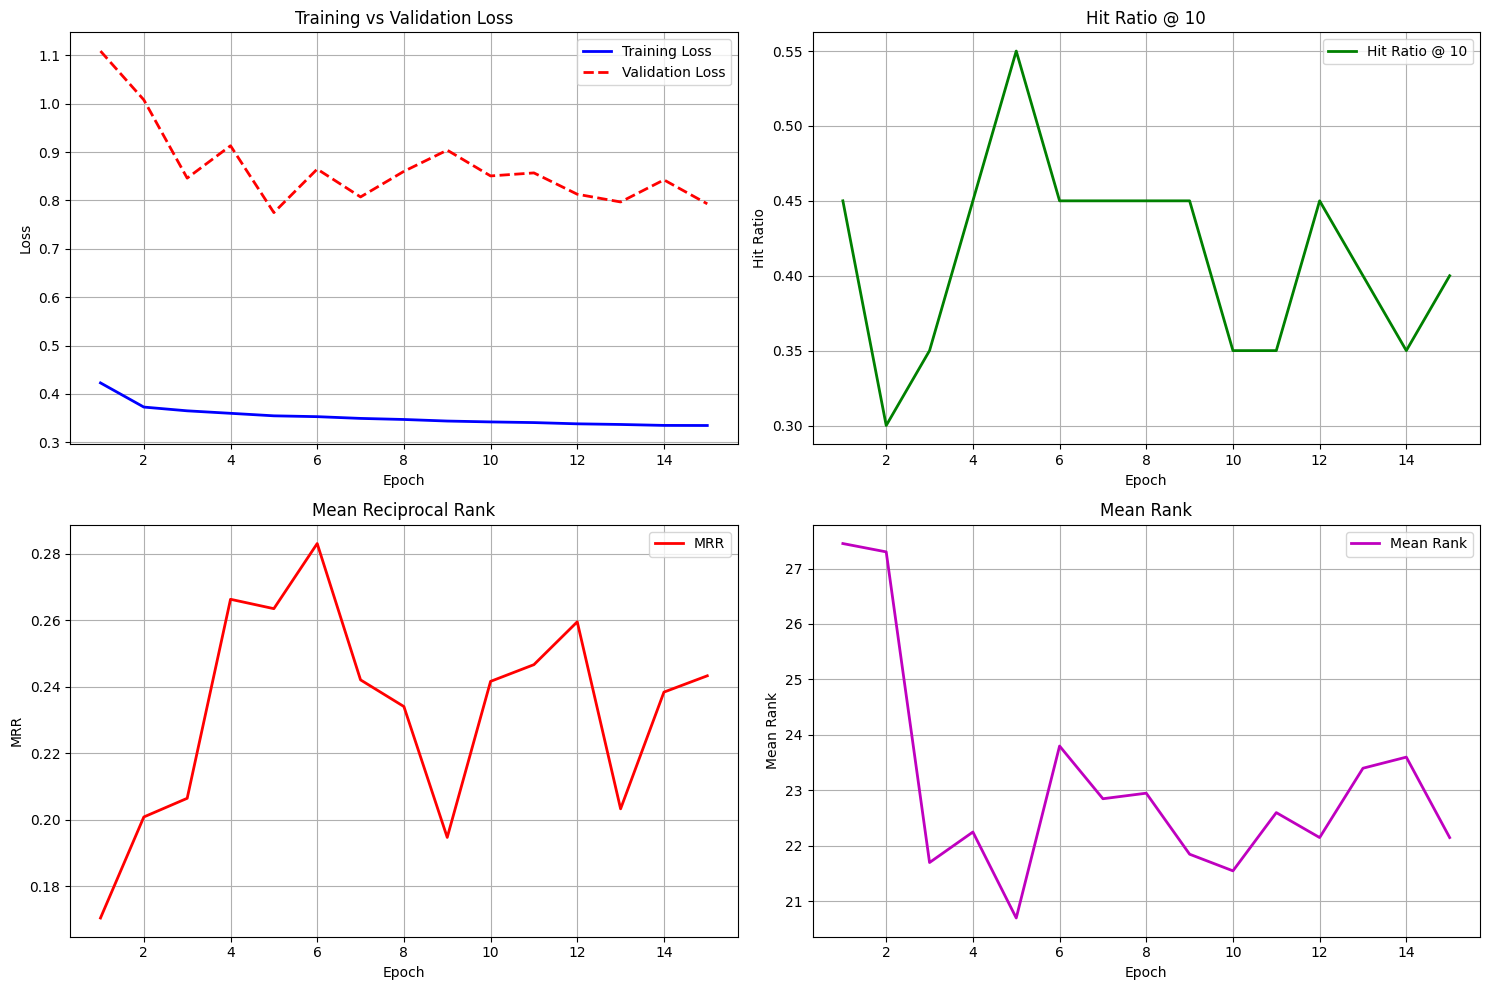

In [75]:
trainer.plot_metrics(save_path="training_metrics.png")

In [58]:

test_candidates = precompute_candidates(candidate_gen, test_ratings, candidate_method="hybrid", num_candidates=100)

model.eval()
with torch.no_grad():
    print(f"Evaluating on test set...")
    test_hit_ratio, test_mrr, test_mean_rank = validate_model_with_features(
        model, test_ratings, test_candidates, device, 
        total_users_to_test=50, k=10
    )

print(f"TEST SET RESULTS:")
print(f"Hit Ratio @ 10: {test_hit_ratio:.3f}")
print(f"Mean Rank: {test_mean_rank:.1f}")
print(f"MRR: {test_mrr:.3f}")


Precomputing candidates for 604 users...


Precomputing candidates:   0%|          | 0/604 [00:00<?, ?it/s]

Precomputed candidates for 604 users
Evaluating on test set...


Validating: 100%|██████████| 50/50 [00:01<00:00, 42.75it/s]

TEST SET RESULTS:
Hit Ratio @ 10: 0.540
Mean Rank: 16.5
MRR: 0.192


In [59]:
# Demonstrate loading complete model using class method
print(f"\n4. LOADING COMPLETE MODEL (CLASS METHOD)")
print("-" * 50)

loaded_model = NCF.load_model(
    filepath=model_save_path,
    ratings=train_ratings,
    feature_processor=feature_processor,
    candidate_generator=candidate_gen
)



4. LOADING COMPLETE MODEL (CLASS METHOD)
--------------------------------------------------
Complete model loaded successfully from models/ncf_trained_model.pth


In [60]:

# Initialize the cold start recommender with the trained model
cold_start_recommender = ColdStartRecommender(
    trained_model=loaded_model,
    feature_processor=feature_processor,
    candidate_generator=candidate_gen,
    movies_df=movies
)

print("Cold Start Recommender initialized successfully!")


Cold Start Recommender initialized successfully!


In [61]:
# DEMONSTRATION: Cold Start Recommendation Examples

print("="*80)
print("COLD START RECOMMENDATION SYSTEM DEMONSTRATION")
print("="*80)

# Example 1: Pure Cold Start - New user with only demographics
print("\n1. PURE COLD START SCENARIO")
print("-" * 50)

new_user_demographics = {
    'gender': 'M',     # Male
    'age': 25,         # 25 years old  
    'occupation': 4    # College/grad student (based on MovieLens occupation codes)
}

print(f"New User Demographics: {new_user_demographics}")

# Get recommendations without any ratings
cold_start_recommendations = cold_start_recommender.recommend_for_new_user(
    user_demographics=new_user_demographics,
    user_ratings=None,  # No ratings yet
    num_recommendations=10
)

print(f"\nTop 10 Cold Start Recommendations:")
for i, (movie_id, title, score) in enumerate(cold_start_recommendations, 1):
    print(f"{i:2d}. {title:<50} (Score: {score:.3f})")

# Example 2: Get onboarding movies for initial rating collection
print(f"\n\n2. ONBOARDING MOVIES FOR RATING COLLECTION")
print("-" * 50)

onboarding_movies = cold_start_recommender.get_onboarding_movies(num_movies=16)

print("Movies to show new user for initial ratings (diverse genres):")
for i, (movie_id, title, genres) in enumerate(onboarding_movies, 1):
    print(f"{i}. {title:<40} | Genres: {genres}")

# Example 3: Warm Cold Start - User has provided some initial ratings
print(f"\n\n3. WARM COLD START SCENARIO")
print("-" * 50)

# Simulate user rating some of the onboarding movies
initial_ratings = [
    (onboarding_movies[0][0], 5),  # Loved the first movie
    (onboarding_movies[1][0], 4),  # Liked the second movie
    (onboarding_movies[4][0], 4),  # Liked the fourth movie
    (onboarding_movies[5][0], 4),  # Liked the fourth movie
    (onboarding_movies[6][0], 4),  # Liked the fourth movie
    (onboarding_movies[7][0], 4),  # Liked the fourth movie
]

print("User's initial ratings:")
for movie_id, rating in initial_ratings:
    movie_title = movies[movies['movie_id'] == movie_id]['title'].iloc[0]
    print(f"  {movie_title:<50} - Rating: {rating}/5")

# Get improved recommendations based on initial ratings
warm_recommendations = cold_start_recommender.recommend_for_new_user(
    user_demographics=new_user_demographics,
    user_ratings=initial_ratings,
    num_recommendations=10
)

print(f"\nTop 10 Recommendations after initial ratings:")
for i, (movie_id, title, score) in enumerate(warm_recommendations, 1):
    print(f"{i:2d}. {title:<50} (Score: {score:.3f})")

print(f"\n\n4. COMPARISON: Different User Demographics")
print("-" * 50)

# Example with different demographics
female_user_demographics = {
    'gender': 'F',     # Female
    'age': 45,         # 45 years old
    'occupation': 0    # Other/not specified
}

print(f"Different User Demographics: {female_user_demographics}")

female_recommendations = cold_start_recommender.recommend_for_new_user(
    user_demographics=female_user_demographics,
    user_ratings=None,
    num_recommendations=5
)

print(f"\nTop 5 Recommendations for different demographic:")
for i, (movie_id, title, score) in enumerate(female_recommendations, 1):
    print(f"{i}. {title:<50} (Score: {score:.3f})")

print(f"\n{'='*80}")
print("Cold Start Recommendation Demonstration Complete!")
print(f"{'='*80}")


COLD START RECOMMENDATION SYSTEM DEMONSTRATION

1. PURE COLD START SCENARIO
--------------------------------------------------
New User Demographics: {'gender': 'M', 'age': 25, 'occupation': 4}

Top 10 Cold Start Recommendations:
 1. Unforgiven (1992)                                  (Score: 0.979)
 2. Life Is Beautiful (La Vita � bella) (1997)         (Score: 0.971)
 3. Home Alone (1990)                                  (Score: 0.959)
 4. Bridge on the River Kwai, The (1957)               (Score: 0.956)
 5. Chicken Run (2000)                                 (Score: 0.953)
 6. Sling Blade (1996)                                 (Score: 0.953)
 7. City Slickers II: The Legend of Curly's Gold (1994) (Score: 0.949)
 8. Akira (1988)                                       (Score: 0.949)
 9. Almost Famous (2000)                               (Score: 0.946)
10. Honey, I Blew Up the Kid (1992)                    (Score: 0.939)


2. ONBOARDING MOVIES FOR RATING COLLECTION
------------------------